### DOES NOT WORK AS INTENDED

In [1]:
import torch
from torch import nn
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import numpy as np
import cv2
import torchmetrics
from tqdm.notebook import tqdm

In [2]:
torch.__version__, torchvision.__version__

('2.0.0+cpu', '0.15.1+cpu')

In [3]:
# Visualize data
import pandas as pd
annotation_path = "./road_condition_data/annotations.csv"
df = pd.read_csv(annotation_path)

df.head(10)

,Unnamed: 0,image_name,has_potholes,rating,is_pitched,has_cracks
0,0,1600.jpg,1,2,1,1
1,1,1601.jpg,1,2,1,1
2,2,1602.jpg,1,2,1,1
3,3,1610.jpg,0,3,1,0
4,4,1611.jpg,0,3,1,0
5,5,1612.jpg,0,3,1,0
6,6,1620.jpg,1,2,1,1
7,7,1621.jpg,1,2,1,1
8,8,1622.jpg,1,2,1,1
9,9,1630.jpg,1,2,1,1


In [4]:
shuffled_df = df.sample(frac=1)

shuffled_df.head(10)

,Unnamed: 0,image_name,has_potholes,rating,is_pitched,has_cracks
5252,5252,India_0003880.jpg,0,2,1,1
5585,5585,India_0009670.jpg,0,2,1,1
6436,6436,India_0024032.jpg,0,2,1,1
8246,8246,India_0054180.jpg,1,2,1,1
14439,14439,UnPavedRoad__3741.jpg,0,1,0,1
21159,21159,UngradedRoad_1111.jpg,0,2,1,1
2121,2121,IMG_20210219_1207271.jpg,0,2,0,1
17025,17025,PotHoles_2991.jpg,1,1,0,0
4462,4462,IMG_20210221_1642482.jpg,0,2,1,1
13256,13256,UnPavedRoad__1270.jpg,0,1,0,1


In [5]:
# Preparing the dataset
class ImageDataset(Dataset):
    def __init__(self, csv, train, test):
        self.csv = csv
        self.train = train
        self.test = test
        self.classes = np.array(self.csv.drop(columns=['image_name', 'Unnamed: 0', 'rating']).columns)
        self.all_image_names = self.csv[:]['image_name']
        self.all_labels = np.array(self.csv.drop(columns=['image_name', 'rating']))
        self.train_ratio = int(0.6*len(self.csv))
        
        if self.train == True:
            print(f"Number of training images: {self.train_ratio}")
            self.image_names = list(self.all_image_names[:self.train_ratio])
            self.labels = list(self.all_labels[:self.train_ratio])
            self.transforms = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=45),
            transforms.ToTensor()
        ])
        
        if self.test == True:
            print(f"Number of testing images: {len(self.csv)-self.train_ratio}")
            self.image_names = list(self.all_image_names[self.train_ratio:])
            self.labels = list(self.all_labels[self.train_ratio:])
            self.transforms = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor()
        ])
        
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, index):
        try:
            image = cv2.imread(f"./road_condition_data/full_dataset/{self.image_names[index]}")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        except:
            image = cv2.imread(f"./road_condition_data/full_dataset/PotHoles_3120.jpg")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transforms(image)
        targets = self.labels[index][1:4]
        
        return (torch.tensor(image, dtype=torch.float32),torch.tensor(targets, dtype=torch.float32))
              

In [6]:
torch.manual_seed(98)

train_dataset = ImageDataset(csv=df,
                             train=True,
                             test=False)
train_dataloader = DataLoader(train_dataset, 
                              batch_size=32, 
                              shuffle=True)

test_dataset = ImageDataset(csv=df,
                           train=False,
                           test=True)
test_dataloader = DataLoader(test_dataset,
                            batch_size=32,
                            shuffle=True)

Number of training images: 13065
Number of testing images: 8711


In [7]:
class_names = train_dataset.classes
class_names

array(['has_potholes', 'is_pitched', 'has_cracks'], dtype=object)

In [8]:
len(test_dataloader), len(train_dataloader)

(273, 409)

In [9]:
def showSingleImage(img:torch.Tensor, lbl:torch.Tensor):
    title =  f"Pothole:{lbl[0]}|Pitch:{lbl[1]}|Crack:{lbl[2]}"
    plt.imshow(img.permute(1,2,0))
    plt.title(title)
    plt.axis(False)

C:\Users\aryal\AppData\Local\Temp\ipykernel_10352\3134679076.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.tensor(image, dtype=torch.float32),torch.tensor(targets, dtype=torch.float32))


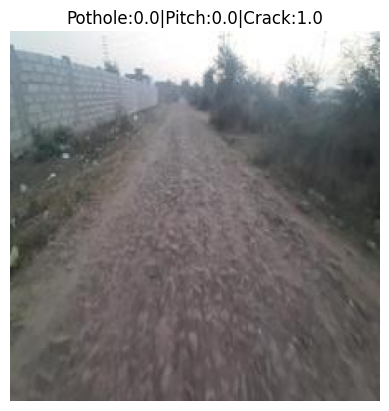

In [10]:
sample_image_batch, sample_label_batch = next(iter(test_dataloader))

sample_image = sample_image_batch[0]
sample_label = sample_label_batch[0]

showSingleImage(sample_image, sample_label)

In [11]:
sample_label

tensor([0., 0., 1.])

In [12]:
# Create Model
class RoadNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layer_1 = nn.Sequential(
            nn.Conv2d(in_channels=3,
                     out_channels=32,
                     kernel_size=5,
                     stride=1,
                     padding=2),
            nn.ReLU()
        )
        self.max_pool = nn.MaxPool2d(kernel_size=2,
                                    stride=2)
        self.conv_layer_2 = nn.Sequential(
            nn.Conv2d(in_channels=32,
                     out_channels=64,
                     kernel_size=5,
                     stride=1,
                     padding=2),
            nn.ReLU()
        )
        
        self.classification_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=64*56*56,
                      out_features=13),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(in_features=13,
                     out_features=6),
            nn.Linear(in_features=6,
                     out_features=3)
            
        )
        
    def forward(self, x):
        x = self.conv_layer_1(x)
        x = self.max_pool(x)
        x = self.conv_layer_2(x)
        x = self.max_pool(x)
        x = self.classification_layer(x)
        return x

In [13]:
model = RoadNet()

In [14]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),
                           lr=0.00001,
                           momentum=0.9)
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=len(class_names))

In [15]:
def training_loop(model:nn.Module,
                 criterion:nn.Module,
                 dataloader: torch.utils.data.DataLoader,
                 optimizer: torch.optim.Optimizer,
                 accuracy_fn=accuracy):
    accumulated_loss, accumulated_acc = 0,0
    for i, (X,y) in enumerate(dataloader):
        preds = model(X)
        loss = criterion(preds, y)
        accumulated_loss += loss
        accumulated_acc += accuracy_fn(preds, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if(i%100==0):
            print(f"TRAIN:: Looked at {i}/{len(dataloader)} batches of 32 images")
    train_loss = accumulated_loss / len(dataloader)
    train_acc = accumulated_acc / len(dataloader)
    return train_loss, train_acc

def testing_loop(model:nn.Module,
                criterion:nn.Module,
                dataloader:torch.utils.data.DataLoader,
                accuracy_fn=accuracy):
    accumulated_loss, accumulated_acc = 0,0
    for i, (X,y) in enumerate(dataloader):
        with torch.inference_mode():
            preds = model(X)
        loss = criterion(preds, y)
        accumulated_loss += loss
        accumulated_acc += accuracy_fn(preds, y)
        if(i%100==0):
            print(f"TEST:: Looked at {i}/{len(dataloader)} batches of 32 images")
    test_loss = accumulated_loss / len(dataloader)
    test_acc = accumulated_acc / len(dataloader)
    return test_loss, test_acc

In [16]:
epochs = 40

train_losses = []
test_losses = []
for epoch in tqdm(range(epochs)):
    print(f"-----\nEpoch:{epoch+1}\n-----")
    train_loss, train_acc = training_loop(model=model,
                                         criterion=loss_fn,
                                         dataloader=train_dataloader,
                                         optimizer=optimizer)
    train_losses.append(train_loss)
    print(f"Training Loss: {train_loss:.5f}")
    
    test_loss, test_acc = testing_loop(model=model,
                                      criterion=loss_fn,
                                      dataloader=test_dataloader)
    test_losses.append(test_loss)
    print(f"Testing Loss: {test_loss:.5f}")

  0%|          | 0/40 [00:00<?, ?it/s]

-----
Epoch:1
-----


C:\Users\aryal\AppData\Local\Temp\ipykernel_10352\3134679076.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.tensor(image, dtype=torch.float32),torch.tensor(targets, dtype=torch.float32))


TRAIN:: Looked at 0/409 batches of 32 images
TRAIN:: Looked at 100/409 batches of 32 images
TRAIN:: Looked at 200/409 batches of 32 images
TRAIN:: Looked at 300/409 batches of 32 images
TRAIN:: Looked at 400/409 batches of 32 images
Training Loss: 1.70805
TEST:: Looked at 0/273 batches of 32 images
TEST:: Looked at 100/273 batches of 32 images
TEST:: Looked at 200/273 batches of 32 images
Testing Loss: 1.76344
-----
Epoch:2
-----
TRAIN:: Looked at 0/409 batches of 32 images
TRAIN:: Looked at 100/409 batches of 32 images
TRAIN:: Looked at 200/409 batches of 32 images
TRAIN:: Looked at 300/409 batches of 32 images
TRAIN:: Looked at 400/409 batches of 32 images
Training Loss: 1.63344
TEST:: Looked at 0/273 batches of 32 images
TEST:: Looked at 100/273 batches of 32 images
TEST:: Looked at 200/273 batches of 32 images
Testing Loss: 1.76714
-----
Epoch:3
-----
TRAIN:: Looked at 0/409 batches of 32 images
TRAIN:: Looked at 100/409 batches of 32 images
TRAIN:: Looked at 200/409 batches of 32 

KeyboardInterrupt: 

In [17]:
train_loss_tensor = torch.tensor(train_losses)
test_loss_tensor = torch.tensor(test_losses)

train_loss_tensor

tensor([1.7080, 1.6334, 1.5771])

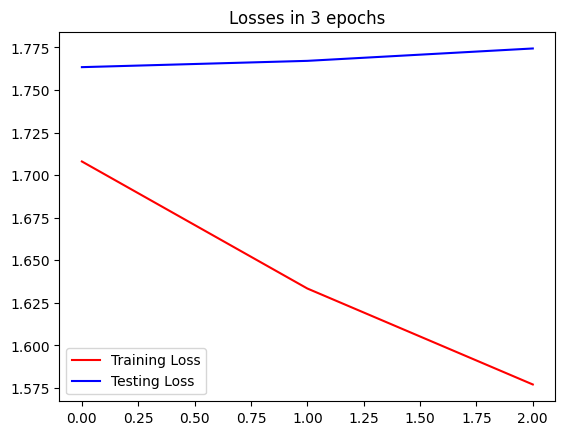

In [18]:
plt.title("Losses in 3 epochs")
plt.plot(train_loss_tensor, c="r", label="Training Loss")
plt.plot(test_loss_tensor, c="b", label="Testing Loss")
plt.legend()
plt.show()

In [ ]:
plt.title("Losses in 40 epochs")
plt.plot(train_loss_tensor, c="r", label="Training Loss")
plt.plot(test_loss_tensor, c="b", label="Testing Loss")
plt.legend()
plt.show()

In [ ]:
"""
to_save = {
    "epochs": 20,
    "model_state": model.state_dict(),
    "optimizer_state": optimizer.state_dict(),
    "train_loss_history": train_losses,
    "test_loss_history": test_losses
}

torch.save(to_save, 'training_state.pt')
"""

In [ ]:
esso_pred = model(sample_image.unsqueeze(0))
temp=esso_pred.squeeze()
esso_pred_probs = torch.softmax(temp,0)
esso_pred_probs

In [ ]:
showSingleImage(sample_image, esso_pred_probs)